# Neural Network Classifier and Regressor 
In this notebook we will take a look at a neural network classifier and regressor. Both of them, take as input a quantum neural network and employ it in specific context.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.optimizers import COBYLA, L_BFGS_B
from qiskit_machine_learning.utils import algorithm_globals

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.circuit.library import QNNCircuit

In [2]:
algorithm_globals.random_seed = 42                     # set the seed so that results won't change simulation from simulation 

## Classification
We start by generating a data set using the method `algorithm-globals.random.random` which returns randomly generated data points taking as input the number of samples and classes.

In [3]:
n_inputs = 2
n_samples  = 20
data_points = 2*algorithm_globals.random.random([n_samples, n_inputs]) - 1
print('Data points generated : ')
print(data_points)

Data points generated : 
[[ 0.5479121  -0.12224312]
 [ 0.71719584  0.39473606]
 [-0.8116453   0.9512447 ]
 [ 0.5222794   0.57212861]
 [-0.74377273 -0.09922812]
 [-0.25840395  0.85352998]
 [ 0.28773024  0.64552323]
 [-0.1131716  -0.54552256]
 [ 0.10916957 -0.87236549]
 [ 0.65526234  0.2633288 ]
 [ 0.51617548 -0.29094806]
 [ 0.94139605  0.78624224]
 [ 0.55676699 -0.61072258]
 [-0.06655799 -0.91239247]
 [-0.69142102  0.36609791]
 [ 0.48952431  0.93501946]
 [-0.34834928 -0.25908059]
 [-0.06088838 -0.62105728]
 [-0.74015699 -0.04859015]
 [-0.5461813   0.33962799]]


In [4]:
data_points_y = 1*(np.sum(data_points, axis = 1) >= 0)
y = 2*data_points_y -1

y_one_hot = np.zeros((n_samples, 2))                    # define a n_samples x 2 matrix (in this case 20 columns  x 2 rows)
for i in range(n_samples):
    y_one_hot[i, data_points_y[i]] = 1                  # fill with all the elements 

print(y_one_hot)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


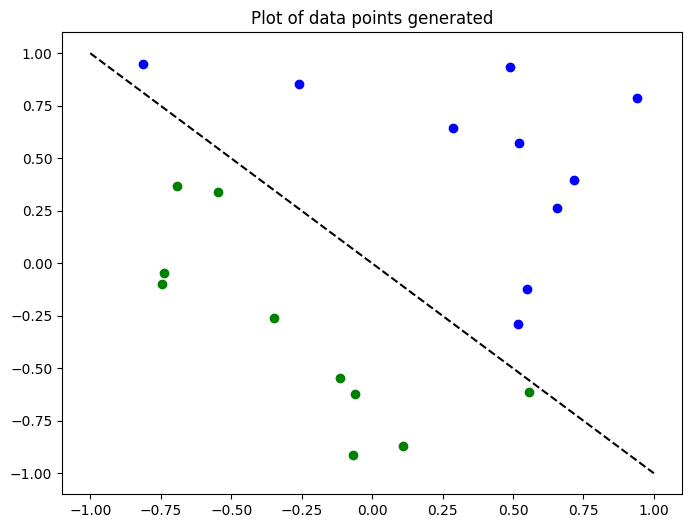

In [5]:
# plot the data 
plt.figure(figsize = [8,6])
plt.title('Plot of data points generated')
for x, y_target in zip(data_points, y):
    if y_target == 1:
        plt.plot(x[0], x[1], c = 'blue', marker = 'o')
    else:
        plt.plot(x[0], x[1], c = 'green', marker = 'o')
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

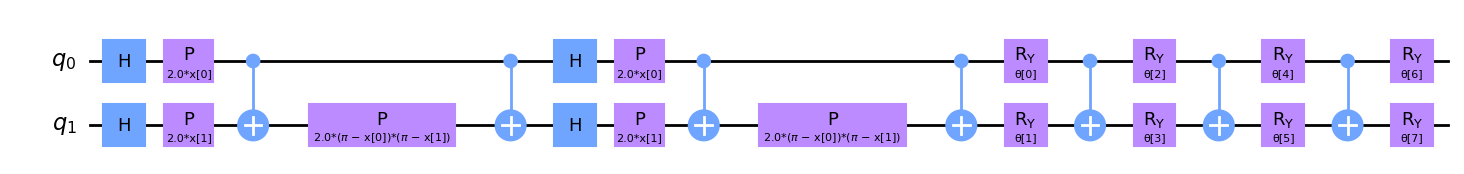

In [6]:
# construct QNN with the QNNCircuit's default ZZFeatureMap feature map and RealAmplitudes ansatz.
qc = QNNCircuit(num_qubits=2)
qc.decompose().draw("mpl", style="clifford")

In [7]:
from qiskit.primitives import Estimator

estimator =  Estimator()
estimator_qnn = EstimatorQNN(circuit = qc, estimator = estimator)

# forward pass, maps input into [-1,1]
estimator_qnn.forward(data_points[0,:], algorithm_globals.random.random(estimator_qnn.num_weights))

# implements a fowrard pass, .forward method takes as input data (in this case the first row ) and the trainable weights 

/var/folders/hb/_vnjt6s167vgsfsr3dc6zm4w0000gn/T/ipykernel_1978/1641949155.py:4: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  estimator_qnn = EstimatorQNN(circuit = qc, estimator = estimator)


array([[0.23521988]])

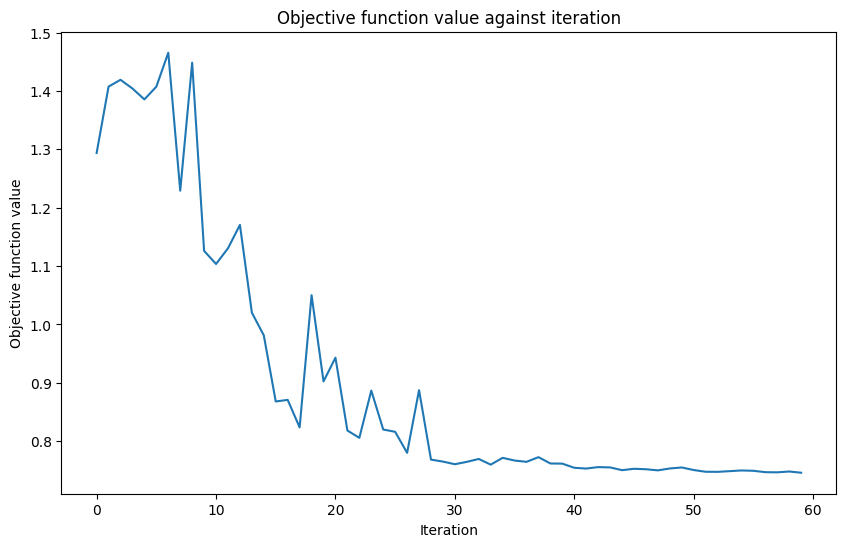

Classifier score : 


0.8

In [8]:
# we can also define a function that draws the evolution of the objective function vs iteration 
def call_back_graph(weights, obj_function):
    clear_output(wait = True)                   
    obj_func_vals.append(obj_function)
    plt.figure(figsize = [10,6])
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(obj_func_vals)), obj_func_vals)
    plt.show()

# construct the neural network classifier 
estimator_classifier  = NeuralNetworkClassifier(
    estimator_qnn, optimizer = COBYLA(maxiter=60), callback = call_back_graph
)

obj_func_vals = []                                          # to store values of the objective function
estimator_classifier.fit(data_points, y)                    # fit the classifier over data 

# score classifier
print('Classifier score : ')
estimator_classifier.score(data_points, y)



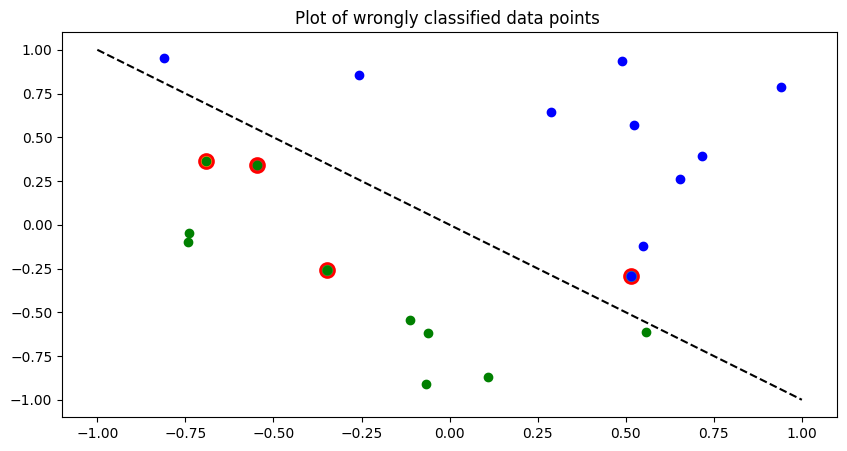

In [9]:
# evaluate each data point 
y_prediction = estimator_classifier.predict(data_points)

# plot the result and highlight the wrongly classified data 

plt.figure(figsize = [10,5])
plt.title(r'Plot of wrongly classified data points ')
for x, y_d, y_predict in zip(data_points, y, y_prediction):
    if y_d == 1:
        plt.plot(x[0], x[1], c = 'blue', marker = 'o')
    else:
        plt.plot(x[0], x[1], c = 'green', marker = 'o' )
    if y_d != y_predict:
        plt.scatter(x[0], x[1], s = 100,  edgecolors = 'r', linewidths = 2, facecolors = None)

plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

In [10]:
weigths = estimator_classifier.weights
print("Weights : ")
print(weigths)

Weights : 
[ 0.86209107 -1.06526254 -0.10663602 -0.39086371  1.0894299   0.59368219
  2.22731471 -1.04769663]


We can do the same using `SamplerQNN` instead of `EstimatorQNN`.

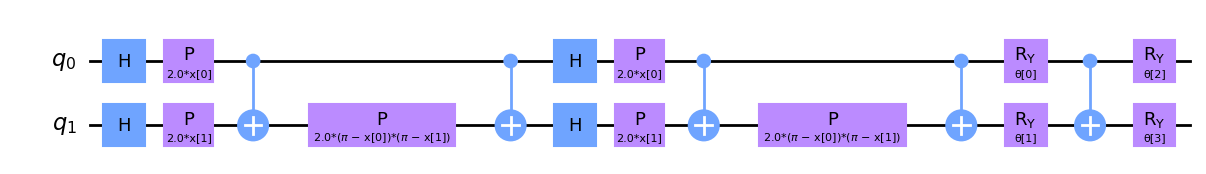

In [11]:
# first we define the quantum circuit using the ZZFeaturemap, which encodes data into a quantum state 
# as ansatz we use the RealAmplitude 

qc = QNNCircuit(ansatz = RealAmplitudes(n_inputs, reps = 1))            # n qubit = n_input and 1 layer 
qc.decompose().draw(output = "mpl", style = "clifford")


In [12]:
# parity maps bitstrings to 0 or 1
def parity(x):
    """
    Function that takes as input an integer x and output 1 if x is even and 0 if x is odd.
    So we have a map from the space where x is defined to the set {0,1}
    """
    return "{:b}".format(x).count("1") % 2


output_shape = 2  # corresponds to the number of classes, possible outcomes of the (parity) mapping

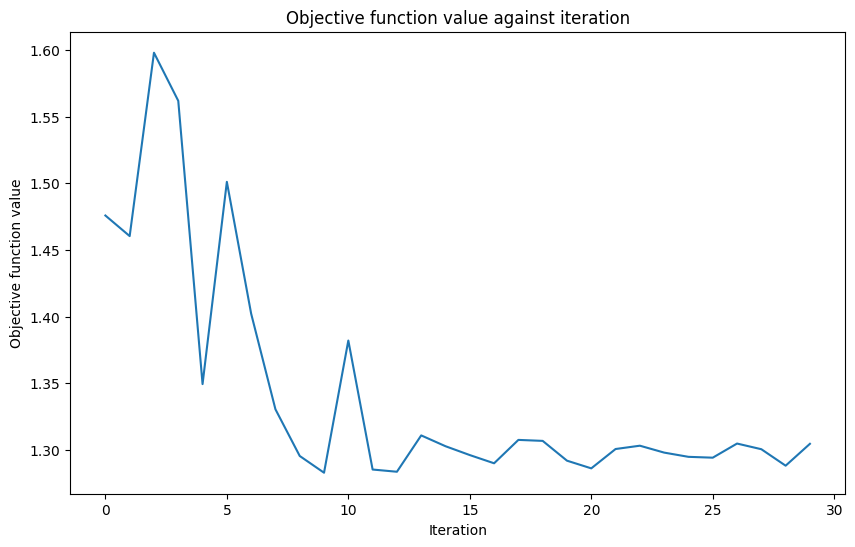

Classifier score : 


0.1

In [13]:
from qiskit.primitives import StatevectorSampler as Sampler
sampler = Sampler()

# construct the quantum sampler 
sampler_qnn = SamplerQNN(circuit = qc,
                         sampler = sampler,
                         output_shape = output_shape,
                         interpret = parity)

# construct the classifier 
classifier_sampler = NeuralNetworkClassifier(neural_network = sampler_qnn,
                                             optimizer = COBYLA(maxiter = 30),
                                             callback = call_back_graph
                                             )

obj_func_vals = []                                          # to store values of the objective function
classifier_sampler.fit(data_points, y)                    # fit the classifier over data 

# score classifier
print('Classifier score : ')
classifier_sampler.score(data_points, y)

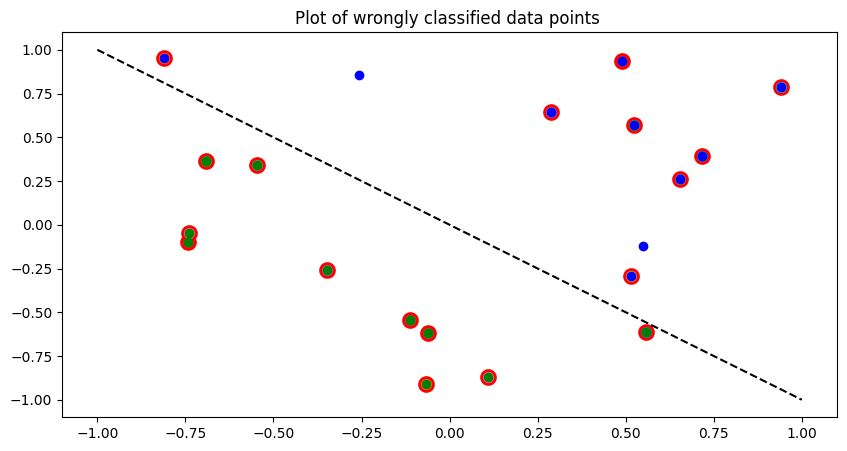

In [14]:
# evaluate each data point 
y_prediction = classifier_sampler.predict(data_points)

# plot the result and highlight the wrongly classified data 

plt.figure(figsize = [10,5])
plt.title(r'Plot of wrongly classified data points ')
for x, y_d, y_predict in zip(data_points, y, y_prediction):
    if y_d == 1:
        plt.plot(x[0], x[1], c = 'blue', marker = 'o')
    else:
        plt.plot(x[0], x[1], c = 'green', marker = 'o' )
    if y_d != y_predict:
        plt.scatter(x[0], x[1], s = 100,  edgecolors = 'r', linewidths = 2, facecolors = None)

plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

In [15]:
# weights classifier 
weights_classifier = classifier_sampler.weights
print("Weights for the classifier : ")
print(weights_classifier)

Weights for the classifier : 
[1.8948404  0.18715597 0.75806904 1.51679914]


# Variational quantum classifier 


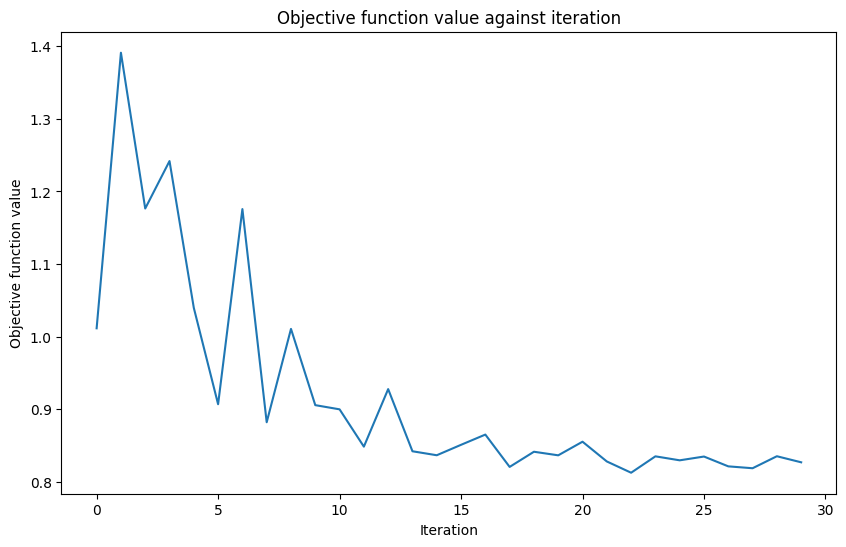

Classifier score with COBYLA : 


0.7

In [16]:
# we can define a VQC using COBYLA optimizer and one using the ADAM optimizer, using the same settings for both of them 

# VQC with cobyla 
vqc_cobyla = VQC( feature_map = ZZFeatureMap(feature_dimension = n_inputs),
          loss = "cross_entropy", 
          ansatz = RealAmplitudes(num_qubits = n_inputs, reps = 1),
          optimizer = COBYLA(maxiter = 30),
          callback = call_back_graph,
          sampler = sampler
)

from qiskit_machine_learning.optimizers import ADAM
# VQC with adam
vqc_adam = VQC( feature_map = ZZFeatureMap(feature_dimension = n_inputs),
          loss = "cross_entropy", 
          ansatz = RealAmplitudes(num_qubits = n_inputs, reps = 1),
          optimizer = ADAM(maxiter = 30),
          callback = call_back_graph,
          sampler = sampler)

obj_func_vals =  []   
                                       
vqc_cobyla.fit(data_points, y)                              # fit the classifier over data


# score classifier
print('Classifier score with COBYLA : ')
vqc_cobyla.score(data_points, y)

In [17]:
# do the same with the ADAM optimizer 

obj_func_vals =  []   
                                       
vqc_adam.fit(data_points, y)                              # fit the classifier over data


# score classifier
print('Classifier score with ADAM : ')
vqc_adam.score(data_points, y)

Classifier score with ADAM : 


0.55

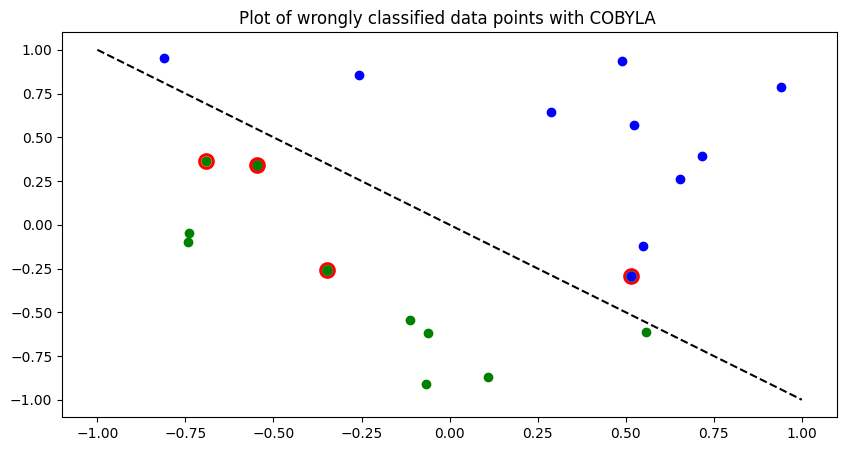

In [18]:
# evaluate each data point 
y_prediction = vqc_cobyla.predict(data_points)

# plot the result and highlight the wrongly classified data 

plt.figure(figsize = [10,5])
plt.title(r'Plot of wrongly classified data points with COBYLA ')
for x, y_d, y_predict in zip(data_points, y, y_prediction):
    if y_d == 1:
        plt.plot(x[0], x[1], c = 'blue', marker = 'o')
    else:
        plt.plot(x[0], x[1], c = 'green', marker = 'o' )
    if y_d != y_predict:
        plt.scatter(x[0], x[1], s = 100,  edgecolors = 'r', linewidths = 2, facecolors = None)

plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

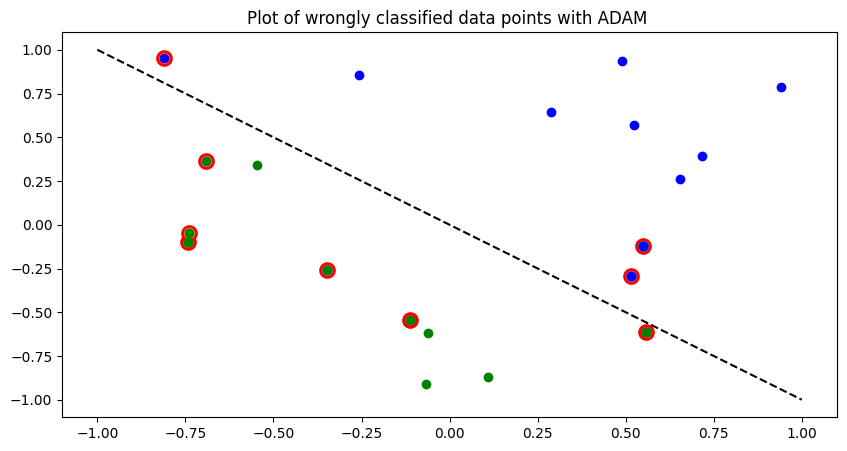

In [19]:
# evaluate each data point 
y_prediction = vqc_adam.predict(data_points)

# plot the result and highlight the wrongly classified data 

plt.figure(figsize = [10,5])
plt.title(r'Plot of wrongly classified data points with ADAM ')
for x, y_d, y_predict in zip(data_points, y, y_prediction):
    if y_d == 1:
        plt.plot(x[0], x[1], c = 'blue', marker = 'o')
    else:
        plt.plot(x[0], x[1], c = 'green', marker = 'o' )
    if y_d != y_predict:
        plt.scatter(x[0], x[1], s = 100,  edgecolors = 'r', linewidths = 2, facecolors = None)

plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

We can also use the VQC in classification problems where we have more than two classes.

In [20]:
# first, we generate the data-set using the sklearn library 
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler

# make_classification()    returns two numpy arrays X, with dimension (n_samples, n_features) and Y of dimension (n_samples,)

X, Y = make_classification(n_samples = 10,
                           n_features = 2,
                           n_classes = 3,
                           n_redundant = 0,   # number of reduntant features 
                           n_clusters_per_class = 1,
                           class_sep = 2.5,
                           random_state = algorithm_globals.random_seed)

print("Generated data : ")
print("X")
print(X)
print("Y")
print(Y)



Generated data : 
X
[[-2.6075354   1.13689984]
 [-3.30671372  1.84881901]
 [ 2.61812006  3.13183215]
 [-2.7937208  -1.92364611]
 [-3.56601243 -3.37756979]
 [-2.40263054  2.70571936]
 [ 2.80546045  2.3872512 ]
 [ 4.21639998  0.62287088]
 [-2.11772816  1.99447882]
 [-1.04686681 -1.41432341]]
Y
[0 0 1 2 2 0 1 1 0 2]


In [21]:
X = MinMaxScaler().fit_transform(X)
print(X)

[[0.12315937 0.69353063]
 [0.03331855 0.80289846]
 [0.79462924 1.        ]
 [0.09923551 0.22335749]
 [0.         0.        ]
 [0.14948859 0.93453887]
 [0.81870152 0.88561454]
 [1.         0.61456347]
 [0.18609709 0.8252753 ]
 [0.32369727 0.30160165]]


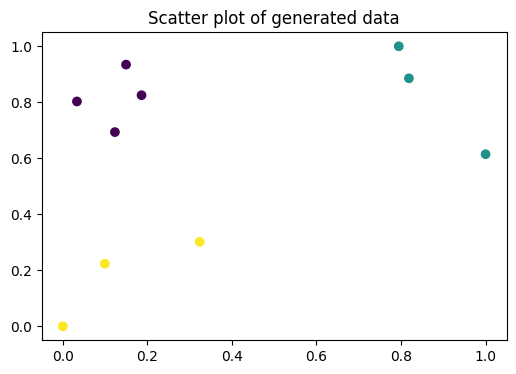

In [22]:
# plot the data 
plt.figure(figsize= [6,4])
plt.title(r'Scatter plot of generated data')
plt.scatter(X[:,0], X[:,1], c = Y)
plt.show()

In [23]:
# we can also give a name to the different labels 
print("Initial labels : " )
print(Y)
Y_labels = np.empty(shape = Y.shape, dtype = str)

# give the different labels 
Y_labels[Y == 0] = "A"
Y_labels[Y == 1] = "B"
Y_labels[Y == 2] = "C"

print("Final labels : ")
print(Y_labels)


Initial labels : 
[0 0 1 2 2 0 1 1 0 2]
Final labels : 
['A' 'A' 'B' 'C' 'C' 'A' 'B' 'B' 'A' 'C']


In [24]:
# just like before we can define a VQC

vqc_cobyla = VQC( num_qubits = 2,
          optimizer = COBYLA(maxiter = 30),
          callback = call_back_graph,
          sampler = sampler
)

vqc_adam = VQC( num_qubits = 2,
          optimizer = ADAM(maxiter = 30),
          callback = call_back_graph,
          sampler = sampler
)

No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.
No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


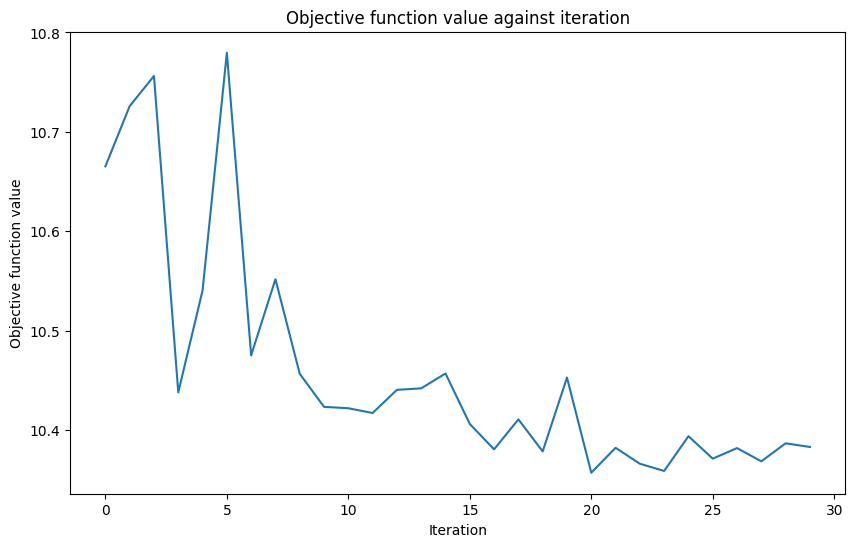

Classifier score with COBYLA : 


0.7

In [25]:
# plot the objectiva function vs iteration
obj_func_vals = []
vqc_cobyla.fit(X, Y_labels)                              # fit the classifier over data


# score classifier
print('Classifier score with COBYLA : ')
vqc_cobyla.score(X, Y_labels)

In [26]:
# plot the objectiva function vs iteration
obj_func_vals = []
vqc_adam.fit(X, Y_labels)                              # fit the classifier over data


# score classifier
print('Classifier score with ADAM : ')
vqc_adam.score(X, Y_labels)

Classifier score with ADAM : 


0.5

In [27]:
prediction_cobyla = vqc_cobyla.predict(X)
prediction_adam = vqc_adam.predict(X)
real_predictions = Y_labels
print("VQC prediction with COBYLA : ")
print(prediction_cobyla)
print("VQC prediction with ADAM : ")
print(prediction_adam)
print("Real labels : ")
print(real_predictions)

VQC prediction with COBYLA : 
['A' 'A' 'B' 'B' 'B' 'A' 'B' 'B' 'A' 'A']
VQC prediction with ADAM : 
['B' 'B' 'B' 'B' 'B' 'A' 'B' 'B' 'A' 'A']
Real labels : 
['A' 'A' 'B' 'C' 'C' 'A' 'B' 'B' 'A' 'C']


# Regression
We will now turn our attention to a regression problem.

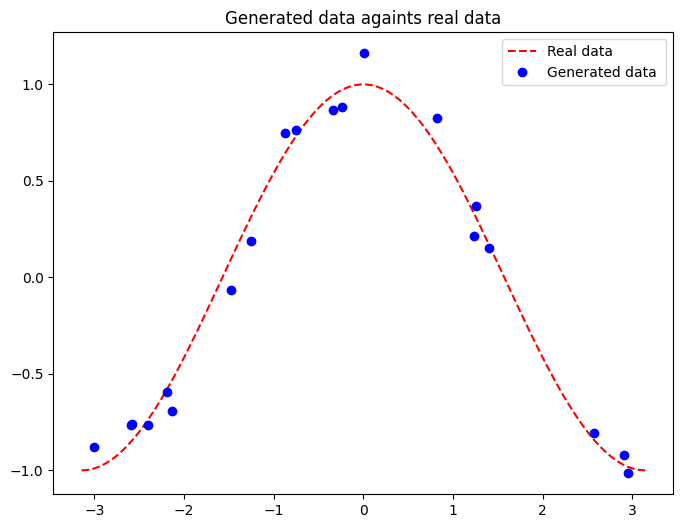

In [28]:
# prepare the data 
n_samples = 20
e = 0.2
lower_bound, upper_bound = -np.pi, np.pi 
x = np.linspace(lower_bound, upper_bound, 100).reshape(100,1)
X = (-lower_bound + upper_bound)*algorithm_globals.random.random(size = [n_samples, 1]) + lower_bound                 # create a data set in the given interval 

y = np.cos(X[:,0]) + e*(2*algorithm_globals.random.random(n_samples)-1)

# plot the data 
plt.figure(figsize = [8,6])
plt.title(r'Generated data againts real data')
plt.plot(x, np.cos(x), "r--", label = 'Real data')
plt.plot(X, y, "bo", label = 'Generated data ')
plt.legend(loc = 'upper right')
plt.show()

In [29]:
# create the feature map and the ansatz

x_param =  Parameter("x")
feature_map = QuantumCircuit(1)
feature_map.ry(x_param, 0)

w_param = Parameter("w")
ansatz = QuantumCircuit(1)
ansatz.ry(w_param, 0)

# quantum circuit
qc = QNNCircuit(ansatz = ansatz, feature_map = feature_map)
qc.draw(output = "mpl", style  = "clifford")

# estimator 
estimator_regression = EstimatorQNN(circuit = qc, estimator = estimator)

# construct the regressor 
regressor = NeuralNetworkRegressor(
    neural_network  = estimator_regression,
    loss = "squared_error",
    optimizer = L_BFGS_B(maxiter = 10),
    callback = call_back_graph
)

/var/folders/hb/_vnjt6s167vgsfsr3dc6zm4w0000gn/T/ipykernel_1978/157071998.py:16: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  estimator_regression = EstimatorQNN(circuit = qc, estimator = estimator)


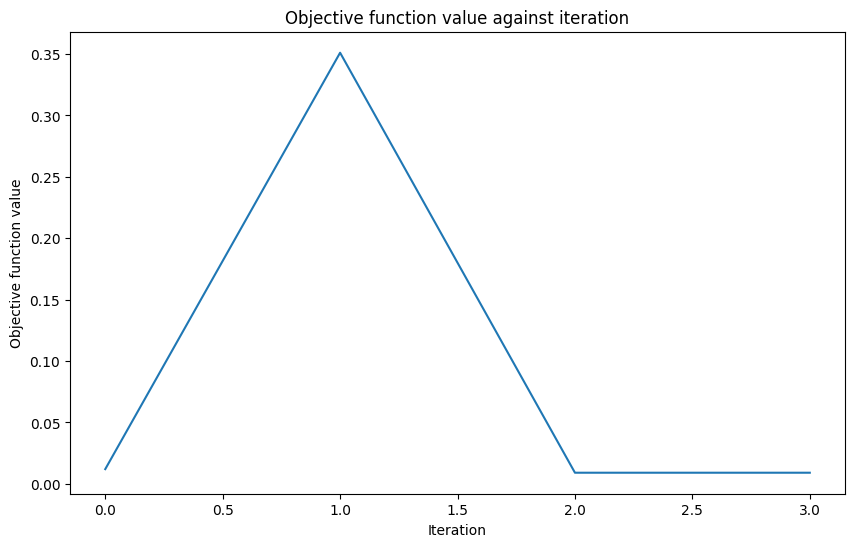

0.9831774849180306

In [30]:
obj_func_vals = []
regressor.fit(X, y)

regressor.score(X,y)

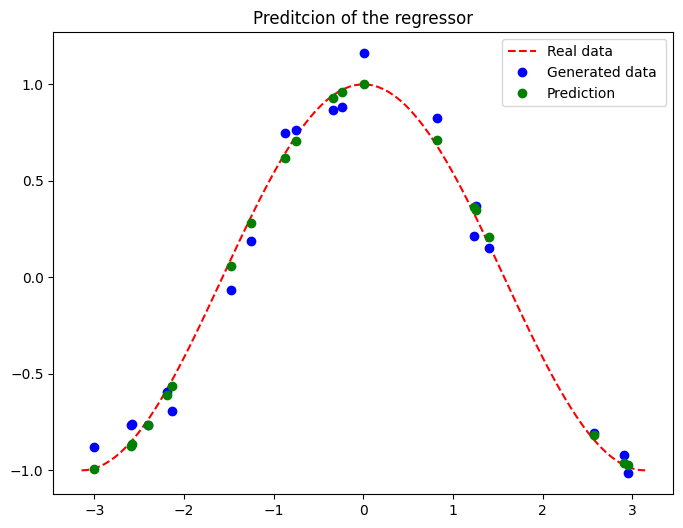

In [31]:
y_predict = regressor.predict(X)                    # prediction of the regressor over data 


# plot the data 
plt.figure(figsize = [8,6])
plt.title(r'Preditcion of the regressor')
plt.plot(x, np.cos(x), "r--", label = 'Real data')
plt.plot(X, y, "bo", label = 'Generated data ')
plt.plot(X, y_predict, "go", label = 'Prediction')
plt.plot()
plt.legend(loc = 'upper right')
plt.show()

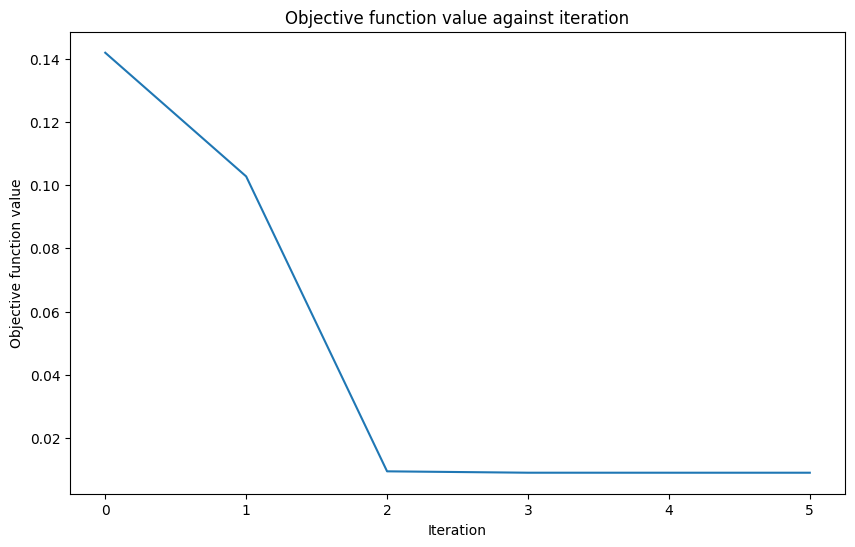

0.9831774849658874

In [32]:
# do the same with a variational quantum regressor
vqr = VQR(
    feature_map = feature_map,
    ansatz = ansatz,
    optimizer = L_BFGS_B(maxiter = 5),
    callback = call_back_graph,
    estimator = estimator
)

obj_func_vals = []
vqr.fit(X, y)

vqr.score(X,y)

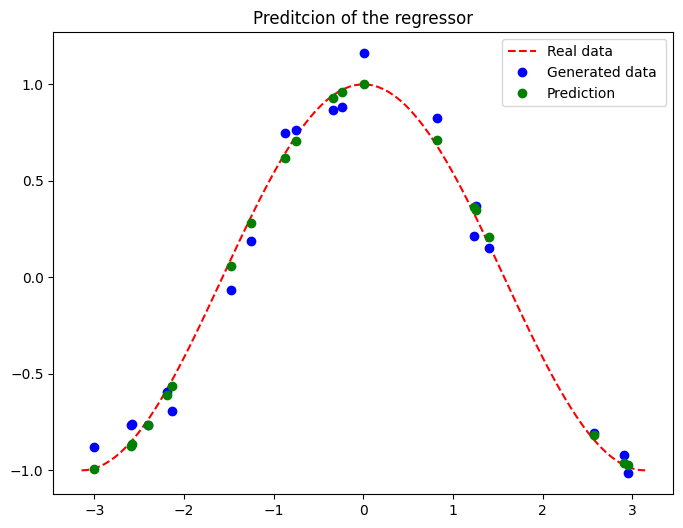

In [33]:
y_predict = vqr.predict(X)                    # prediction of the vqr over data 


# plot the data 
plt.figure(figsize = [8,6])
plt.title(r'Preditcion of the regressor')
plt.plot(x, np.cos(x), "r--", label = 'Real data')
plt.plot(X, y, "bo", label = 'Generated data ')
plt.plot(X, y_predict, "go", label = 'Prediction')
plt.plot()
plt.legend(loc = 'upper right')
plt.show()